https://www.alpha-i.co/blog/MNIST-for-ML-beginners-The-Bayesian-Way.html

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from edward.models import Categorical, Normal
import edward as ed
import pandas as pd
import pickle
ed.set_seed(314159)

In [2]:
# Use the TensorFlow method to download and/or load the data.
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
#two-layer neural network.
def neural_network(x, W_0, W_1, b_0, b_1):
    h = tf.matmul(x, W_0) + b_0
    h = tf.tanh(h)
    #h = tf.exp(tf.negative(tf.square(h)))
    h = tf.matmul(h, W_1) + b_1
    return h

def display_draws(loss, train_x, EPOCH_NUM):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 3.5))
    plt.plot(np.arange(EPOCH_NUM), loss / len(train_x), label='Train')
    plt.legend(fontsize=20)
    plt.xlabel('Epoch', fontsize=15)
    plt.ylabel('Negated ELBO', fontsize=15)
    plt.show()

In [4]:
%run optim.py

In [6]:
total = mnist.train.num_examples #number of training examples
N = total/10   # number of images in a minibatch.
D = 784   # number of features.
K = 10    # number of classes.
P = 100   # number of neurons.

In [1]:
m0=100
mcbatch = range(m0,m0+10*100)

In [7]:
# Create a placeholder to hold the data (in minibatches) in a TensorFlow graph.
x = tf.placeholder(tf.float32, [None, D])
# Normal(0,1) priors for the variables. Note that the syntax assumes TensorFlow 1.1.
w0 = Normal(loc=tf.zeros([D, P]), scale=tf.ones([D, P]))
b0 = Normal(loc=tf.zeros(P), scale=tf.ones(P))
w1 = Normal(loc=tf.zeros([P, K]), scale=tf.ones([P, K]))
b1 = Normal(loc=tf.zeros(K), scale=tf.ones(K))
# Categorical likelihood for classication.
y =Categorical(neural_network(x, w0,w1, b0, b1))

In [8]:
# Contruct the q(w) and q(b). in this case we assume Normal distributions.
qw0 = Normal(loc=tf.Variable(tf.random_normal([D, P])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, P]))))
qb0 = Normal(loc=tf.Variable(tf.random_normal([P])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([P]))))
qw1 = Normal(loc=tf.Variable(tf.random_normal([P, K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([P, K]))))
qb1 = Normal(loc=tf.Variable(tf.random_normal([K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([K]))))

In [9]:
epoch_num = 200
train_losssgd = np.zeros(epoch_num)

In [10]:
# We use a placeholder for the labels in anticipation of the traning data.
y_ph = tf.placeholder(tf.int32, [N])
# Define the VI inference technique, ie. minimise the KL divergence between q and p.
inference = elbo_optimizer({w0: qw0, b0: qb0,w1:qw1,b1:qb1}, data={y:y_ph})

In [11]:
learning_rate = 5e-6
optimizer = tf.train.GradientDescentOptimizer(learning_rate)

In [12]:
inference.initialize(optimizer=optimizer,n_print=100,n_samples=mcbatch)

In [13]:
# We will use an interactive session.
sess = tf.InteractiveSession()
# Initialise all the vairables in the session.
tf.global_variables_initializer().run()

In [14]:
obj = inference.build_loss_and_gradients(tf.trainable_variables())

In [15]:
newloss = obj[0]
newvars = obj[1][0:4]
newgrads = obj[1][4:8]

# SGD

In [15]:
for i in (0,total/N):
    X_batch, Y_batch = mnist.train.next_batch(N)
    # TensorFlow method gives the label data in a one hot vetor format. We convert that into a single label.
    Y_batch = np.argmax(Y_batch,axis=1)
    grads = tf.gradients(newloss, tf.trainable_variables())
    var_updates = []
    var_list = tf.trainable_variables()
    for grad, var in zip(grads, var_list):
        var_updates.append(var.assign_sub(learning_rate * grad))
    train_op = tf.group(*var_updates)
    sess.run(train_op,feed_dict={x: X_batch, y_ph: Y_batch})
    #info_dict = inference.update(feed_dict={x: X_batch, y_ph: Y_batch})
        
train_losssgd[0] = sess.run(newloss,feed_dict={x: X_batch, y_ph: Y_batch})

In [15]:
for epoch in range(1,epoch_num):
    for i in (0,total/N):
        print(epoch)
        X_batch, Y_batch = mnist.train.next_batch(N)
        # TensorFlow method gives the label data in a one hot vetor format. We convert that into a single label.
        Y_batch = np.argmax(Y_batch,axis=1)
        grads = tf.gradients(newloss, tf.trainable_variables())
        var_updates = []
        var_list = tf.trainable_variables()
        for grad, var in zip(grads, var_list):
            var_updates.append(var.assign_sub(learning_rate * grad))
        train_op = tf.group(*var_updates)
        sess.run(train_op,feed_dict={x: X_batch, y_ph: Y_batch})
        #info_dict = inference.update(feed_dict={x: X_batch, y_ph: Y_batch})
        
    train_losssgd[epoch] = sess.run(newloss,feed_dict={x: X_batch, y_ph: Y_batch})

0
0
1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
10
11
11
12
12
13
13
14
14
15
15
16
16
17
17
18
18
19
19
20
20
21
21
22
22
23
23
24
24
25
25
26
26
27
27
28
28
29
29


In [16]:
for epoch in range(1,epoch_num):
    for _ in range(0, total, N):
        X_batch, Y_batch = mnist.train.next_batch(N)
        # TensorFlow method gives the label data in a one hot vetor format. We convert that into a single label.
        Y_batch = np.argmax(Y_batch,axis=1)
        info_dict = inference.update(feed_dict={x: X_batch, y_ph: Y_batch})
        
    train_losssgd[epoch] = info_dict['loss']
    inference.print_progress(info_dict)

1900/5000 [ 38%] ███████████                    ETA: 131s | Loss: 91506.188 8

In [19]:
sgd = train_losssgd[0:100]
#save loss
with open('sgdloss', 'wb') as fp:
    pickle.dump(sgd, fp)

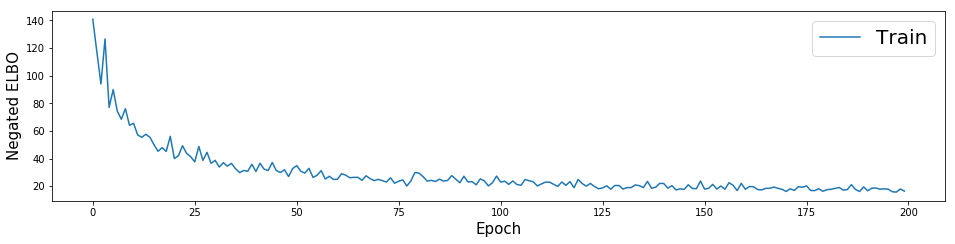

In [21]:
display_draws(train_losssgd, X_batch, epoch_num)

# SAG

In [5]:
total = mnist.train.num_examples #number of training examples
N = total/10  # number of images in a minibatch.
D = 784   # number of features.
K = 10    # number of classes.
P = 100   # number of neurons.
# Create a placeholder to hold the data (in minibatches) in a TensorFlow graph.
x = tf.placeholder(tf.float32, [None, D])
# Normal(0,1) priors for the variables. Note that the syntax assumes TensorFlow 1.1.
w0 = Normal(loc=tf.zeros([D, P]), scale=tf.ones([D, P]))
b0 = Normal(loc=tf.zeros(P), scale=tf.ones(P))
w1 = Normal(loc=tf.zeros([P, K]), scale=tf.ones([P, K]))
b1 = Normal(loc=tf.zeros(K), scale=tf.ones(K))
# Categorical likelihood for classication.
y =Categorical(neural_network(x, w0,w1, b0, b1))
# Contruct the q(w) and q(b). in this case we assume Normal distributions.
qw0 = Normal(loc=tf.Variable(tf.random_normal([D, P])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, P]))))
qb0 = Normal(loc=tf.Variable(tf.random_normal([P])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([P]))))
qw1 = Normal(loc=tf.Variable(tf.random_normal([P, K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([P, K]))))
qb1 = Normal(loc=tf.Variable(tf.random_normal([K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([K]))))
epoch_num = 200
train_losssag = np.zeros(epoch_num)
# We use a placeholder for the labels in anticipation of the traning data.
y_ph = tf.placeholder(tf.int32, [N])
# Define the VI inference technique, ie. minimise the KL divergence between q and p.
inference = elbo_optimizer({w0: qw0, b0: qb0,w1:qw1,b1:qb1}, data={y:y_ph})

learning_rate = 5e-6
optimizer = tf.train.GradientDescentOptimizer(learning_rate)

inference.initialize(optimizer=optimizer,n_print=100,n_samples=mcbatch)

# We will use an interactive session.
sess = tf.InteractiveSession()
# Initialise all the vairables in the session.
tf.global_variables_initializer().run()
obj = inference.build_loss_and_gradients(tf.trainable_variables())

newloss = obj[0]
newvars = obj[1][0:4]
newgrads = obj[1][4:8]

In [6]:
gradients = []#First pass over the data with SGD (keeping in memory all the gradients)
for _ in range(0,total, N):
    print(_)
    X_batch, Y_batch = mnist.train.next_batch(N)
    # TensorFlow method gives the label data in a one hot vetor format. We convert that into a single label.
    Y_batch = np.argmax(Y_batch,axis=1)
    grads = tf.gradients(newloss, tf.trainable_variables())
    var_updates = []
    var_list = tf.trainable_variables()
    for grad, var in zip(grads, var_list):
        var_updates.append(var.assign_sub(learning_rate * grad))
    train_op = tf.group(*var_updates)
    gradients.append(grads)
    sess.run(train_op,feed_dict={x: X_batch, y_ph: Y_batch})
    #info_dict = inference.update(feed_dict={x: X_batch, y_ph: Y_batch})
        
train_losssag[0] = sess.run(newloss,feed_dict={x: X_batch, y_ph: Y_batch})

0
5500
11000
16500
22000
27500
33000
38500
44000
49500


In [7]:
#SAG (replacing the gradients of the selectied indices)
for epoch in range(1,epoch_num):
    for i in range(0,total/N):
        print(epoch)
        X_batch, Y_batch = mnist.train.next_batch(N)
        # TensorFlow method gives the label data in a one hot vetor format. We convert that into a single label.
        Y_batch = np.argmax(Y_batch,axis=1)
        grads = tf.gradients(newloss, tf.trainable_variables())
        gradients[i] = grads
        var_updates = []
        var_list = tf.trainable_variables()
        for gradstemp in gradients:
            for grad, var in zip(gradstemp, var_list):
                var_updates.append(var.assign_sub(learning_rate * grad))
        train_op = tf.group(*var_updates)
        sess.run(train_op,feed_dict={x: X_batch, y_ph: Y_batch})
        #info_dict = inference.update(feed_dict={x: X_batch, y_ph: Y_batch})
        
    train_losssag[epoch] = sess.run(newloss,feed_dict={x: X_batch, y_ph: Y_batch})

1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
7
8
8
8
8
8
8
8
8
8
8
9
9
9
9
9
9
9
9
9
9
10
10
10
10
10
10
10
10
10
10
11
11
11
11
11
11
11
11
11
11
12
12
12
12
12
12
12
12
12
12
13
13
13
13
13
13
13
13
13
13
14
14
14
14
14
14
14
14
14
14
15
15
15
15
15
15
15
15
15
15
16
16
16
16
16
16
16
16
16
16
17
17
17
17
17
17
17
17
17
17
18
18
18
18
18
18
18
18
18
18
19
19
19
19
19
19
19
19
19
19
20
20
20
20
20
20
20
20
20
20
21
21
21
21
21
21
21
21
21
21
22
22
22
22
22
22
22
22
22
22
23
23
23
23
23
23
23
23
23
23
24
24
24
24
24
24
24
24
24
24
25
25
25
25
25
25
25
25
25
25
26
26
26
26
26
26
26
26
26
26
27
27
27
27
27
27
27
27
27
27
28
28
28
28
28
28
28
28
28
28
29
29
29
29
29
29
29
29
29
29
30
30
30
30
30
30
30
30
30
30
31
31
31
31
31
31
31
31
31
31
32
32
32
32
32
32
32
32
32
32
33
33
33
33
33
33
33
33
33
33
34
34
34
34
34
34
34
34
34
34
35
35
35
35
35
35
35
35
35
35
36
36
36
36
36
36
36
36
36
36
37
37
37
3

KeyboardInterrupt: 

In [13]:
sag = train_losssag[0:100]

In [18]:
#save loss
with open('sagloss', 'wb') as fp:
    pickle.dump(sag, fp)

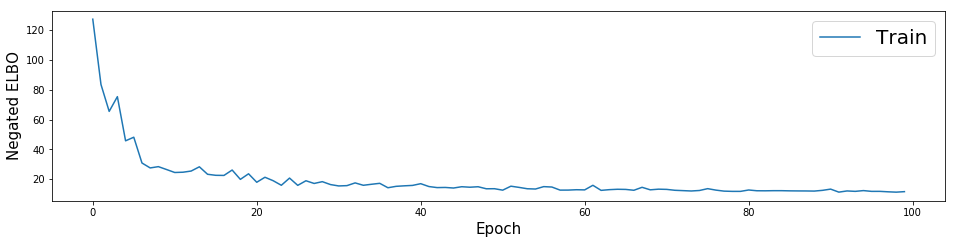

In [9]:
display_draws(train_losssag[0:100], X_batch, 100)

# ADAM

In [16]:
total = mnist.train.num_examples #number of training examples
N = total/10  # number of images in a minibatch.
D = 784   # number of features.
K = 10    # number of classes.
P = 100   # number of neurons.
# Create a placeholder to hold the data (in minibatches) in a TensorFlow graph.
x = tf.placeholder(tf.float32, [None, D])
# Normal(0,1) priors for the variables. Note that the syntax assumes TensorFlow 1.1.
w0 = Normal(loc=tf.zeros([D, P]), scale=tf.ones([D, P]))
b0 = Normal(loc=tf.zeros(P), scale=tf.ones(P))
w1 = Normal(loc=tf.zeros([P, K]), scale=tf.ones([P, K]))
b1 = Normal(loc=tf.zeros(K), scale=tf.ones(K))
# Categorical likelihood for classication.
y =Categorical(neural_network(x, w0,w1, b0, b1))
# Contruct the q(w) and q(b). in this case we assume Normal distributions.
qw0 = Normal(loc=tf.Variable(tf.random_normal([D, P])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, P]))))
qb0 = Normal(loc=tf.Variable(tf.random_normal([P])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([P]))))
qw1 = Normal(loc=tf.Variable(tf.random_normal([P, K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([P, K]))))
qb1 = Normal(loc=tf.Variable(tf.random_normal([K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([K]))))
epoch_num = 200
train_lossadam = np.zeros(epoch_num)
# We use a placeholder for the labels in anticipation of the traning data.
y_ph = tf.placeholder(tf.int32, [N])
# Define the VI inference technique, ie. minimise the KL divergence between q and p.
inference = elbo_optimizer({w0: qw0, b0: qb0,w1:qw1,b1:qb1}, data={y:y_ph})

learning_rate = 5e-3
optimizer = tf.train.AdamOptimizer(learning_rate)

inference.initialize(optimizer=optimizer,n_print=100,n_samples=mcbatch)

# We will use an interactive session.
sess = tf.InteractiveSession()
# Initialise all the vairables in the session.
tf.global_variables_initializer().run()
obj = inference.build_loss_and_gradients(tf.trainable_variables())

newloss = obj[0]
newvars = obj[1][0:4]
newgrads = obj[1][4:8]

In [17]:
for epoch in range(0,epoch_num):
    for _ in range(0, total, N):
        X_batch, Y_batch = mnist.train.next_batch(N)
        # TensorFlow method gives the label data in a one hot vetor format. We convert that into a single label.
        Y_batch = np.argmax(Y_batch,axis=1)
        info_dict = inference.update(feed_dict={x: X_batch, y_ph: Y_batch})
        
    train_lossadam[epoch] = info_dict['loss']
    inference.print_progress(info_dict)

2000/5000 [ 40%] ████████████                   ETA: 119s | Loss: 58034.180 

In [18]:
adam = train_lossadam[0:100]
#save loss
with open('adamloss', 'wb') as fp:
    pickle.dump(adam, fp)

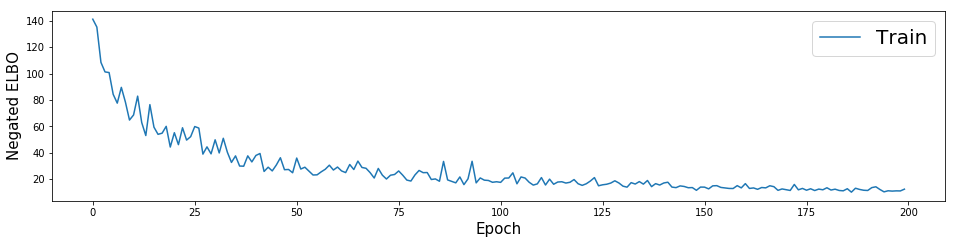

In [11]:
display_draws(train_lossadam, X_batch, epoch_num)

# RMSPROP

In [5]:
total = mnist.train.num_examples #number of training examples
N = total/10  # number of images in a minibatch.
D = 784   # number of features.
K = 10    # number of classes.
P = 100   # number of neurons.
# Create a placeholder to hold the data (in minibatches) in a TensorFlow graph.
x = tf.placeholder(tf.float32, [None, D])
# Normal(0,1) priors for the variables. Note that the syntax assumes TensorFlow 1.1.
w0 = Normal(loc=tf.zeros([D, P]), scale=tf.ones([D, P]))
b0 = Normal(loc=tf.zeros(P), scale=tf.ones(P))
w1 = Normal(loc=tf.zeros([P, K]), scale=tf.ones([P, K]))
b1 = Normal(loc=tf.zeros(K), scale=tf.ones(K))
# Categorical likelihood for classication.
y =Categorical(neural_network(x, w0,w1, b0, b1))
# Contruct the q(w) and q(b). in this case we assume Normal distributions.
qw0 = Normal(loc=tf.Variable(tf.random_normal([D, P])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, P]))))
qb0 = Normal(loc=tf.Variable(tf.random_normal([P])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([P]))))
qw1 = Normal(loc=tf.Variable(tf.random_normal([P, K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([P, K]))))
qb1 = Normal(loc=tf.Variable(tf.random_normal([K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([K]))))
epoch_num = 200
train_lossrms = np.zeros(epoch_num)
# We use a placeholder for the labels in anticipation of the traning data.
y_ph = tf.placeholder(tf.int32, [N])
# Define the VI inference technique, ie. minimise the KL divergence between q and p.
inference = elbo_optimizer({w0: qw0, b0: qb0,w1:qw1,b1:qb1}, data={y:y_ph})

learning_rate = 5e-3
optimizer = tf.train.RMSPropOptimizer(learning_rate)

inference.initialize(optimizer=optimizer,n_print=100,n_samples=mcbatch)

# We will use an interactive session.
sess = tf.InteractiveSession()
# Initialise all the vairables in the session.
tf.global_variables_initializer().run()
obj = inference.build_loss_and_gradients(tf.trainable_variables())

newloss = obj[0]
newvars = obj[1][0:4]
newgrads = obj[1][4:8]

In [7]:
for epoch in range(0,epoch_num):
    for _ in range(0, total, N):
        X_batch, Y_batch = mnist.train.next_batch(N)
        # TensorFlow method gives the label data in a one hot vetor format. We convert that into a single label.
        Y_batch = np.argmax(Y_batch,axis=1)
        info_dict = inference.update(feed_dict={x: X_batch, y_ph: Y_batch})
        
    train_lossrms[epoch] = info_dict['loss']
    inference.print_progress(info_dict)

2000/5000 [ 40%] ████████████                   ETA: 136s | Loss: 40068.44188

In [9]:
rms = train_lossrms[0:100]
#save loss
with open('rmsloss', 'wb') as fp:
    pickle.dump(rms, fp)

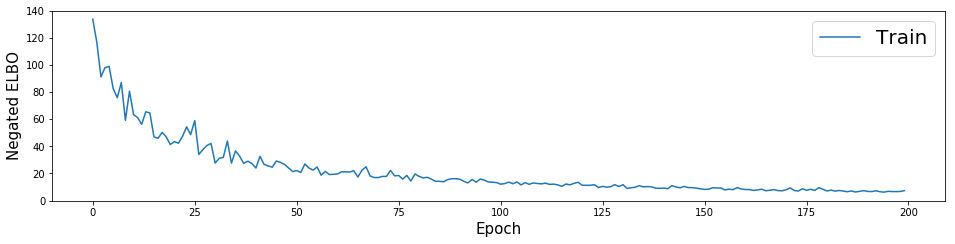

In [8]:
display_draws(train_lossrms, X_batch, epoch_num)

# Momentum

http://ruder.io/optimizing-gradient-descent/index.html#momentum

In [5]:
total = mnist.train.num_examples #number of training examples
N = total/10  # number of images in a minibatch.
D = 784   # number of features.
K = 10    # number of classes.
P = 100  # number of neurons.
# Create a placeholder to hold the data (in minibatches) in a TensorFlow graph.
x = tf.placeholder(tf.float32, [None, D])
# Normal(0,1) priors for the variables. Note that the syntax assumes TensorFlow 1.1.
w0 = Normal(loc=tf.zeros([D, P]), scale=tf.ones([D, P]))
b0 = Normal(loc=tf.zeros(P), scale=tf.ones(P))
w1 = Normal(loc=tf.zeros([P, K]), scale=tf.ones([P, K]))
b1 = Normal(loc=tf.zeros(K), scale=tf.ones(K))
# Categorical likelihood for classication.
y =Categorical(neural_network(x, w0,w1, b0, b1))
# Contruct the q(w) and q(b). in this case we assume Normal distributions.
qw0 = Normal(loc=tf.Variable(tf.random_normal([D, P])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, P]))))
qb0 = Normal(loc=tf.Variable(tf.random_normal([P])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([P]))))
qw1 = Normal(loc=tf.Variable(tf.random_normal([P, K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([P, K]))))
qb1 = Normal(loc=tf.Variable(tf.random_normal([K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([K]))))
epoch_num = 200
train_lossmoment = np.zeros(epoch_num)
# We use a placeholder for the labels in anticipation of the traning data.
y_ph = tf.placeholder(tf.int32, [N])
# Define the VI inference technique, ie. minimise the KL divergence between q and p.
inference = elbo_optimizer({w0: qw0, b0: qb0,w1:qw1,b1:qb1}, data={y:y_ph})

learning_rate = 5e-5
momentum = 5e-5
optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)

inference.initialize(optimizer=optimizer,n_print=100,n_samples=mcbatch)

# We will use an interactive session.
sess = tf.InteractiveSession()
# Initialise all the vairables in the session.
tf.global_variables_initializer().run()
obj = inference.build_loss_and_gradients(tf.trainable_variables())

newloss = obj[0]
newvars = obj[1][0:4]
newgrads = obj[1][4:8]

In [6]:
for i in (0,total/N):
    X_batch, Y_batch = mnist.train.next_batch(N)
    # TensorFlow method gives the label data in a one hot vetor format. We convert that into a single label.
    Y_batch = np.argmax(Y_batch,axis=1)
    grads = tf.gradients(newloss, tf.trainable_variables())
    var_updates = []
    var_list = tf.trainable_variables()
    for grad, var in zip(grads, var_list):
        var_updates.append(var.assign_sub(learning_rate * grad))
    train_op = tf.group(*var_updates)
    sess.run(train_op,feed_dict={x: X_batch, y_ph: Y_batch})
    #info_dict = inference.update(feed_dict={x: X_batch, y_ph: Y_batch})
        
train_lossmoment[0] = sess.run(newloss,feed_dict={x: X_batch, y_ph: Y_batch})

In [7]:
for epoch in range(1,epoch_num):
    for _ in range(0, total, N):
        X_batch, Y_batch = mnist.train.next_batch(N)
        # TensorFlow method gives the label data in a one hot vetor format. We convert that into a single label.
        Y_batch = np.argmax(Y_batch,axis=1)
        info_dict = inference.update(feed_dict={x: X_batch, y_ph: Y_batch})
        
    train_lossmoment[epoch] = info_dict['loss']
    inference.print_progress(info_dict)

1900/5000 [ 38%] ███████████                    ETA: 129s | Loss: 55836.3912

In [9]:
moment = train_lossmoment[0:100]
#save loss
with open('momentloss', 'wb') as fp:
    pickle.dump(moment, fp)

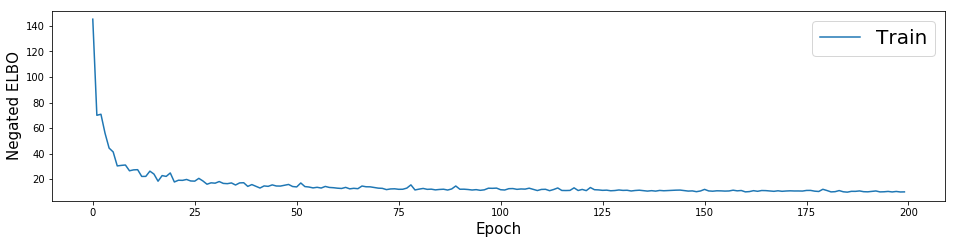

In [8]:
display_draws(train_lossmoment, X_batch, epoch_num)

# Comparison

In [13]:
with open ('losses/sagloss', 'rb') as fp:
    sag = pickle.load(fp)
with open ('losses/sgdloss', 'rb') as fp:
    sgd = pickle.load(fp)
with open ('losses/adamloss', 'rb') as fp:
    adam = pickle.load(fp)
with open ('losses/rmsloss', 'rb') as fp:
    rms = pickle.load(fp)
with open ('losses/momentloss', 'rb') as fp:
    moment = pickle.load(fp)

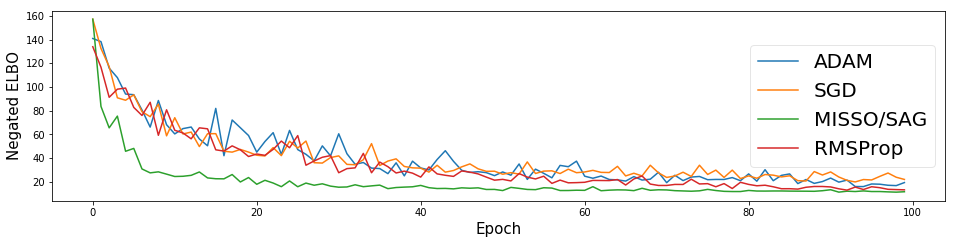

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 3.5))
plt.plot(np.arange(100), adam / len(X_batch), label='ADAM')
plt.plot(np.arange(100), sgd / len(X_batch), label='SGD')
plt.plot(np.arange(100), sag / len(X_batch), label='MISSO/SAG')
plt.plot(np.arange(100), rms / len(X_batch), label='RMSProp')
leg = plt.legend(fontsize=20,fancybox=True, loc='right')
leg.get_frame().set_alpha(0.5)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Negated ELBO', fontsize=15)
plt.show()

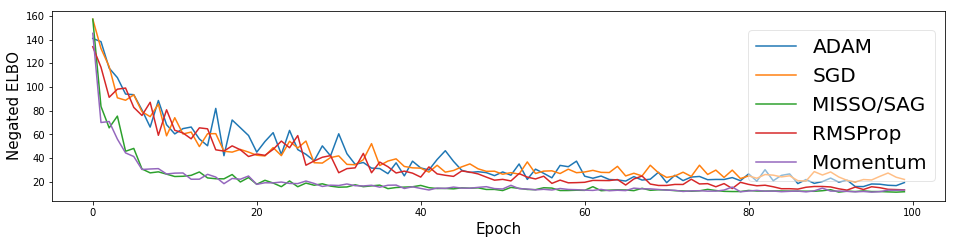

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 3.5))
plt.plot(np.arange(100), adam / len(X_batch), label='ADAM')
plt.plot(np.arange(100), sgd / len(X_batch), label='SGD')
plt.plot(np.arange(100), sag / len(X_batch), label='MISSO/SAG')
plt.plot(np.arange(100), rms / len(X_batch), label='RMSProp')
plt.plot(np.arange(100), moment / len(X_batch), label='Momentum')
leg = plt.legend(fontsize=20,fancybox=True, loc='right')
leg.get_frame().set_alpha(0.5)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Negated ELBO', fontsize=15)
plt.show()

# Draft

In [27]:
X_batch, Y_batch = mnist.train.next_batch(N)
Y_batch = np.argmax(Y_batch,axis=1)

In [34]:
obj = inference.build_loss_and_gradients(tf.trainable_variables())

In [41]:
newloss = obj[0]
newvars = obj[1][0:4]
newgrads = obj[1][4:8]

In [47]:
grads = tf.gradients(newloss, tf.trainable_variables())

In [48]:
var_updates = []
var_list = tf.trainable_variables()
for grad, var in zip(grads, var_list):
    var_updates.append(var.assign_sub(learning_rate * grad))
train_op = tf.group(*var_updates)

In [50]:
sess.run(train_op,feed_dict={x: X_batch, y_ph: Y_batch})

In [67]:
sess.run(newloss,feed_dict={x: X_batch, y_ph: Y_batch})

776452.38

In [37]:
info_dict = inference.update(feed_dict={x: X_batch, y_ph: Y_batch})

In [28]:
gradandvar = optimizer.compute_gradients(build[0])

In [29]:
optimizer.apply_gradients(gradandvar)

<tf.Operation 'GradientDescent' type=NoOp>

In [48]:
var_grad_val = sess.run(elbo_optimizer, feed_dict={x: X_batch, y_ph: Y_batch})

FailedPreconditionError: Attempting to use uninitialized value Variable
	 [[Node: Variable/read = Identity[T=DT_FLOAT, _class=["loc:@Variable"], _device="/job:localhost/replica:0/task:0/cpu:0"](Variable)]]

Caused by op u'Variable/read', defined at:
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/karimimohammedbelhal/Desktop/ongoing/hostnfly/deeptech/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/karimimohammedbelhal/Desktop/ongoing/hostnfly/deeptech/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/karimimohammedbelhal/Desktop/ongoing/hostnfly/deeptech/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/Users/karimimohammedbelhal/Desktop/ongoing/hostnfly/deeptech/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/karimimohammedbelhal/Desktop/ongoing/hostnfly/deeptech/lib/python2.7/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/karimimohammedbelhal/Desktop/ongoing/hostnfly/deeptech/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/karimimohammedbelhal/Desktop/ongoing/hostnfly/deeptech/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/karimimohammedbelhal/Desktop/ongoing/hostnfly/deeptech/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/karimimohammedbelhal/Desktop/ongoing/hostnfly/deeptech/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/karimimohammedbelhal/Desktop/ongoing/hostnfly/deeptech/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/karimimohammedbelhal/Desktop/ongoing/hostnfly/deeptech/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/karimimohammedbelhal/Desktop/ongoing/hostnfly/deeptech/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/karimimohammedbelhal/Desktop/ongoing/hostnfly/deeptech/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/karimimohammedbelhal/Desktop/ongoing/hostnfly/deeptech/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/karimimohammedbelhal/Desktop/ongoing/hostnfly/deeptech/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/karimimohammedbelhal/Desktop/ongoing/hostnfly/deeptech/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/karimimohammedbelhal/Desktop/ongoing/hostnfly/deeptech/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2822, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/karimimohammedbelhal/Desktop/ongoing/hostnfly/deeptech/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-874706bc0cfb>", line 2, in <module>
    qw0 = Normal(loc=tf.Variable(tf.random_normal([D, P])),
  File "/Users/karimimohammedbelhal/Desktop/ongoing/hostnfly/deeptech/lib/python2.7/site-packages/tensorflow/python/ops/variables.py", line 200, in __init__
    expected_shape=expected_shape)
  File "/Users/karimimohammedbelhal/Desktop/ongoing/hostnfly/deeptech/lib/python2.7/site-packages/tensorflow/python/ops/variables.py", line 319, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/Users/karimimohammedbelhal/Desktop/ongoing/hostnfly/deeptech/lib/python2.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1303, in identity
    result = _op_def_lib.apply_op("Identity", input=input, name=name)
  File "/Users/karimimohammedbelhal/Desktop/ongoing/hostnfly/deeptech/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/Users/karimimohammedbelhal/Desktop/ongoing/hostnfly/deeptech/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/karimimohammedbelhal/Desktop/ongoing/hostnfly/deeptech/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value Variable
	 [[Node: Variable/read = Identity[T=DT_FLOAT, _class=["loc:@Variable"], _device="/job:localhost/replica:0/task:0/cpu:0"](Variable)]]


In [11]:
for epoch in range(epoch_num):
    for _ in range(0, total, N):
        X_batch, Y_batch = mnist.train.next_batch(N)
        # TensorFlow method gives the label data in a one hot vetor format. We convert that into a single label.
        Y_batch = np.argmax(Y_batch,axis=1)
        info_dict = inference.update(feed_dict={x: X_batch, y_ph: Y_batch})
        
    train_lossbb[epoch] = info_dict['loss']
    inference.print_progress(info_dict)

2000/5000 [ 40%] ████████████                   ETA: 116s | Loss: 22174.6914

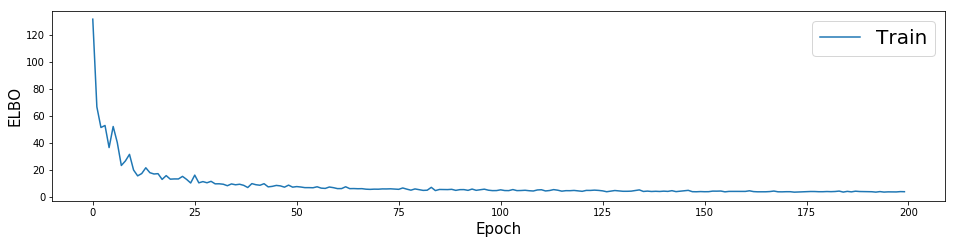

In [12]:
display_draws(train_lossbb, X_batch, epoch_num)